# Development of new features for polymerist

In [1]:
import networkx as nx
from rdkit import Chem

import mbuild
from mbuild.compound import Compound
from mbuild.conversion import load, load_smiles, from_rdkit, to_smiles, to_pybel
from mbuild.lib.recipes.polymer import Polymer

comp = mbuild.Compound()

/home/timber/miniconda3/envs/polymerist-env/lib/python3.11/site-packages/mdtraj/formats/__init__.py:6: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  from .xtc import XTCTrajectoryFile
/home/timber/miniconda3/envs/polymerist-env/lib/python3.11/site-packages/mdtraj/geometry/order.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import parse_version
/home/timber/miniconda3/envs/polymerist-env/lib/python3.11/site-packages/pkg_resources/__init__.py:2846: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/home/timber/miniconda3/envs/polymerist-env/lib/python3.11/site-packages/mbuild/recipes/__i

## Developing monomer graphs

### String/graph translation (SMILES-like)

In [2]:
from polymerist.polymers.monographs import MonomerGraph

In [3]:
# test = f'{tests[-2]}.{tests[-2]}'
tests = [
    '[a]{-1}[A]({2-3}[Bee]{2=5}[C]{5=2}[Bee]{3-6}[Bee])({2-3}[Bee]({3-6}[Bee]){3-}[a]){-}[A]{2-2}[Bee]{3-6}[Bee]',
    '[A]{1-2}[B]{6=5}[C]{#}[D]',
]
seq = [0]
test = '.'.join(tests[i] for i in seq)
print(test)

[a]{-1}[A]({2-3}[Bee]{2=5}[C]{5=2}[Bee]{3-6}[Bee])({2-3}[Bee]({3-6}[Bee]){3-}[a]){-}[A]{2-2}[Bee]{3-6}[Bee]


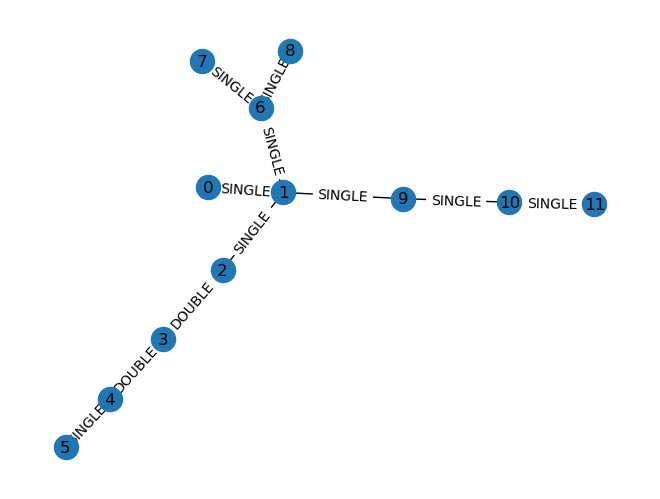

In [4]:
G = MonomerGraph.from_SMIDGE(test)
G.visualize(label_monomers=False)

### "Alphabet" of monomer fragment chemical information 

ethane-1,2-diol_TERM


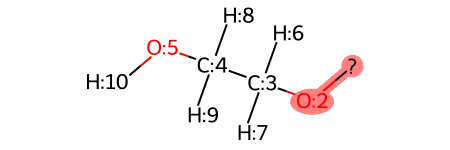

furan-2,5-dicarboxylic acid_TERM


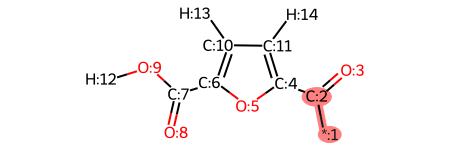

ethane-1,2-diol_MID


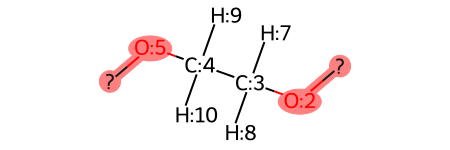

furan-2,5-dicarboxylic acid_MID


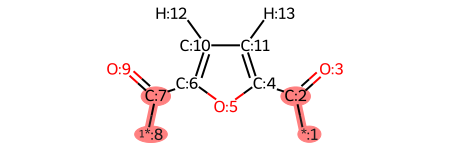

In [5]:
from string import ascii_uppercase 
from polymerist.monomers import MonomerGroup
from polymerist.rdutils.bonding.portlib import get_ports
from polymerist.rdutils.labeling.molwise import clear_atom_map_nums


parent_monomers = {
    'ethane-1,2-diol' : 'OCCO',
    'furan-2,5-dicarboxylic acid' : 'O=C(O)c1ccc(C(=O)O)o1',
}
monomer_aliases = {
    mononame : lett*3
        for mononame, lett in zip(parent_monomers.keys(), ascii_uppercase)
}

monogrp = MonomerGroup.from_file('poly(ethane-1,2-diol-co-furan-2,5-dicarboxylic acid).json')
moldict, monosmiles = {}, {}
for mononame, rdmol in monogrp.iter_rdmols():
    for i, port in enumerate(get_ports(rdmol)):
        rdmol.GetAtomWithIdx(port.linker.GetIdx()).SetIsotope(i)

    print(mononame)
    display(rdmol)
    moldict[   mononame] = rdmol
    monosmiles[mononame] = Chem.MolToSmiles(clear_atom_map_nums(rdmol))

### Defining monomer infomration 

In [24]:
from typing import Optional
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from dataclasses import dataclass, field


from polymerist.genutils.fileutils.jsonio.serialize import JSONSerializable, TypeSerializer
from polymerist.rdutils.bonding.portlib import get_num_linkers, get_num_ports
from polymerist.monomers.specification import expanded_SMILES, compliant_mol_SMARTS

@dataclass
class MonomerFragmentInfo:
    '''Naming and in-line chemical encodings for a monomer unit within a polymer chain'''
    name   : str
    smiles : str
    exp_smiles : Optional[str] = field(default=None, init=False, repr=False)
    smarts     : Optional[str] = field(default=None)
    category   : Optional[str] = field(default=None)

    n_atoms       : int = field(init=False)
    functionality : int = field(init=False)
    contribution  : int = field(init=False)

    def __post_init__(self) -> None:
        self.exp_smiles = expanded_SMILES(self.smiles, assign_map_nums=True)
        if self.smarts is None:
            self.smarts = compliant_mol_SMARTS(self.exp_smiles)

        tempmol = self.rdmol
        self.n_atoms = tempmol.GetNumAtoms()
        self.functionality = get_num_ports(tempmol) # get_num_linkers(tempmol) 
        self.contribution = self.n_atoms - self.functionality

    @property
    def rdmol(self) -> Chem.Mol:
        return Chem.MolFromSmiles(self.smiles, sanitize=False)

class MonomerFragmentInfoSerializer(TypeSerializer):
    '''JSON encoder and decoder patterns for MonomerInfo objects'''
    python_type = MonomerFragmentInfo

    @staticmethod
    def encode(python_obj : MonomerFragmentInfo) -> dict[str, JSONSerializable]:
        return python_obj.__dict__

    @staticmethod
    def decode(json_obj : dict[str, JSONSerializable]) -> MonomerFragmentInfo:
        params = {
            attrname : v
                for attrname, v in json_obj.items()
                if MonomerFragmentInfo.__dataclass_fields__[attrname].init
        }
        return MonomerFragmentInfo(**params)

In [25]:
from polymerist.monomers import specification

mono_infos = {}
for mononame, smiles in monosmiles.items():
    parent_mononame = mononame.split('_')[0]
    parent_smiles = parent_monomers[parent_mononame]
    parent_alias  = monomer_aliases[parent_mononame]

    mono_info = MonomerFragmentInfo(
        name=mononame,
        smiles=smiles,
        # smarts=specification.compliant_mol_SMARTS(smiles),
        category=parent_smiles,
    )
    alias = parent_alias.lower() if (mono_info.functionality == 1) else parent_alias.upper()
    mono_infos[alias] = mono_info
mono_infos

/home/timber/Documents/Python/polymerist_dev/polymerist/polymerist/monomers/specification.py:127: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  LOGGER.warn(f'Cleaned {num_repl} SMARTS atom query aberrations introduced by RDKit')
Cleaned 10 SMARTS atom query aberrations introduced by RDKit
/home/timber/Documents/Python/polymerist_dev/polymerist/polymerist/monomers/specification.py:127: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  LOGGER.warn(f'Cleaned {num_repl} SMARTS atom query aberrations introduced by RDKit')
Cleaned 14 SMARTS atom query aberrations introduced by RDKit
/home/timber/Documents/Python/polymerist_dev/polymerist/polymerist/monomers/specification.py:127: DeprecationWarning: The 'warn' method is deprecated, use 'warning' instead
  LOGGER.warn(f'Cleaned {num_repl} SMARTS atom query aberrations introduced by RDKit')
Cleaned 10 SMARTS atom query aberrations introduced by RDKit
/home/timber/Documents/Python/polymer

{'aaa': MonomerFragmentInfo(name='ethane-1,2-diol_TERM', smiles='*OC([H])([H])C([H])([H])O[H]', smarts='[*:1]-[#8D2+0:2]-[#6D4+0:3](-[#6D4+0:4](-[#8D2+0:5]-[#1D1+0:10])(-[#1D1+0:8])-[#1D1+0:9])(-[#1D1+0:6])-[#1D1+0:7]', category='OCCO', n_atoms=10, functionality=1, contribution=9),
 'bbb': MonomerFragmentInfo(name='furan-2,5-dicarboxylic acid_TERM', smiles='*C(=O)C1=C([H])C([H])=C(C(=O)O[H])O1', smarts='[*:1]-[#6D3+0:2](=[#8D1+0:3])-[#6D3+0:4]1=[#6D3+0:5](-[#1D1+0:12])-[#6D3+0:6](-[#1D1+0:13])=[#6D3+0:7](-[#6D3+0:8](=[#8D1+0:9])-[#8D2+0:10]-[#1D1+0:14])-[#8D2+0:11]-1', category='O=C(O)c1ccc(C(=O)O)o1', n_atoms=14, functionality=1, contribution=13),
 'AAA': MonomerFragmentInfo(name='ethane-1,2-diol_MID', smiles='*OC([H])([H])C([H])([H])O[1*]', smarts='[*:1]-[#8D2+0:2]-[#6D4+0:3](-[#6D4+0:4](-[#8D2+0:5]-[1*:6])(-[#1D1+0:9])-[#1D1+0:10])(-[#1D1+0:7])-[#1D1+0:8]', category='OCCO', n_atoms=10, functionality=2, contribution=8),
 'BBB': MonomerFragmentInfo(name='furan-2,5-dicarboxylic acid_MI

### Defining polymer composition class

In [26]:
from enum import Enum, StrEnum, auto

from polymerist.genutils.fileutils.jsonio.serialize import JSONSerializable, TypeSerializer, MultiTypeSerializer
from polymerist.genutils.fileutils.jsonio.jsonify import make_jsonifiable, JSONifiable
from polymerist.polymers.monographs import MonomerGraph, MonomerGraphSerializer
from polymerist.rdutils.bonding.portlib import get_num_linkers, get_ports


MONOMER_CHARS = 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
class MonomerNeighborMismatch(Enum):
    '''For annotating the various ways in which a piece of monomer information in a monomer alphabet does not match a monomer graph'''
    NONE = 0
    COUNT = auto()
    BONDTYPE = auto()
    NO_FLAVOR = auto()
    DIFF_FLAVOR = auto()
    NOT_NEIGHBORS = auto()


PolymerStructureSerializer = MultiTypeSerializer(MonomerGraphSerializer, MonomerFragmentInfoSerializer)
@make_jsonifiable(type_serializer=PolymerStructureSerializer)
@dataclass
class PolymerStructure:
    '''Encodes a multi-scale structural representation of a polymer topology'''
    mono_alphabet : dict[str, MonomerFragmentInfo] 
    monograph : MonomerGraph

    single_char_mononames : dict[str, str] = field(default_factory=dict, init=False) 

    def __post_init__(self) -> None:
        '''Post-process init attributes'''
        self.single_char_mononames = { # remapping from the assigned monomers names to single characters for mbuild compatibility
            mononame : remap_char
                for (mononame, remap_char) in zip(self.mono_alphabet.keys(), MONOMER_CHARS)
        }

        self.validate_monoinfo_is_compatible() # will raise targetted exceptions if incompatible
        self.assign_monoinfo_to_monograph()

    @property
    def node_info_map(self) -> dict[int, MonomerFragmentInfo]:
        '''Map from node indices to relevant monomer information'''
        return {
            node_id : self.mono_alphabet[alias]
                for node_id, alias in nx.get_node_attributes(self.monograph, self.monograph.MONOMER_NAME_ATTR).items()
        }
    
    @property
    def pdb_substructures(self) -> dict[str, list[str]]:
        '''Substructure dict formatted for the OpenFF Topology.from_pdb RDKit wrapper hook'''
        return {
            monoinfo.name : [mono_info.smarts]
                for monoinfo in self.mono_alphabet.values()
        }
    
    @property
    def num_atoms(self) -> int:
        '''Total number of atoms in the topology specified'''
        return sum(nx.get_node_attributes(self.monograph, 'contribution').values())

    # validation
    def monoalpha_surjective_to_monograph(self) -> bool:
        '''Check whether the monomer alphabet covers all monomer types defined in the Graph'''
        return self.monograph.unique_monomer_names.issubset(set(self.mono_alphabet.keys()))

    def monoalpha_neighbors_are_valid(self) -> tuple[bool, int, MonomerNeighborMismatch]:
        '''Determine whether and why adjacent monomers in the monomer graph do (or don't) have compatible chemical info'''
        for node_idx, neighbor_dict in self.monograph.adj.items():
            # 1) check that the number of neighbors in the graph matches the number of intermonomer bonding sites given chemically
            neighbor_dict = dict(neighbor_dict) # convert from networkx object to vanilla dict
            degree = len(neighbor_dict) # self.monograph.degree[node_idx]
            if (degree != self.node_info_map[node_idx].functionality):
                return False, node_idx, MonomerNeighborMismatch.COUNT
            
            # 2) check that all reported neighbor nodes are actually adjacent in the graph
            found_ports = set()
            for i, flavor in self.monograph.get_flavor_dict(node_idx).items():
                if i not in neighbor_dict:
                    return False, node_idx, MonomerNeighborMismatch.NOT_NEIGHBORS
                
                nb_bond_info = neighbor_dict.pop(i)
                found_ports.add( (flavor, nb_bond_info[self.monograph.BONDTYPE_ATTR]) )

            # 3) check that every neighbors has been provided a flavor
            if neighbor_dict:
                return False, node_idx, MonomerNeighborMismatch.NO_FLAVOR # at least one of the neighbors must nnot have had a flavor provided

            # 4) check that the provided flavors match those chemically specified
            monoinfo = self.mono_alphabet[self.monograph.get_monomer_name(node_idx)]
            portinfo = set(
                (port.flavor, port.bond.GetBondType())
                    for port in get_ports(monoinfo.rdmol)
            )
            if (portinfo != found_ports):
                return False, node_idx, MonomerNeighborMismatch.DIFF_FLAVOR
        else:
            return True, -1, MonomerNeighborMismatch.NONE
        
    def validate_monoinfo_is_compatible(self) -> None:
        if not self.monoalpha_surjective_to_monograph():
            raise ValueError('Provided monomer alphabet does not cover all monomers in the corresponding monomer graph')
        
        nb_match, mismatch_idx, reason = self.monoalpha_neighbors_are_valid()
        if not nb_match:
            raise ValueError(f'Graph node {mismatch_idx} (designation "{self.monograph.get_monomer_name(mismatch_idx)}") mismatched (reason : {reason.name})')
    
    def assign_monoinfo_to_monograph(self) -> None:
        '''Map the chemical info for each unique monomer onto corresponding monomer nodes in the monomer graph'''
        node_info_map = {
            node_idx : self.mono_alphabet[self.monograph.monomer_name(node_idx)].__dict__
                for node_idx in self.monograph.nodes
        }
        nx.set_node_attributes(self.monograph, node_info_map)

[aaa]{0-1}[BBB]{0-1}[AAA]{0-1}[BBB]{0-1}[AAA]{0-1}[BBB]{0-1}[AAA]{0-0}[bbb]


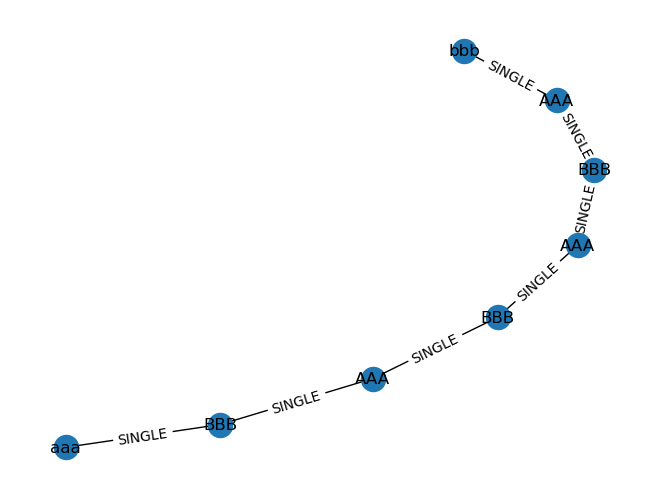

In [27]:
import networkx as nx
from polymerist.genutils.textual import delimiters
from polymerist.polymers.monographs import MonomerGraph

smidge = 'aBABABAb'
# smidge = '{2-3}'.join(smidge)
# smidge = '{0-1}'.join(smidge)
smidge = '{0-1}'.join(smidge[:-1]) + '{0-0}' + smidge[-1]
smidge = delimiters.square_brackets_around_letters(smidge)
smidge = ''.join(3*c if c.isalpha() else c for c in smidge)
print(smidge)

monograph = MonomerGraph.from_smidge(smidge)
monograph.draw()

poly = PolymerStructure(
    mono_alphabet=mono_infos,
    monograph=monograph
)
poly.to_file('test.json')

In [28]:
poly.monograph.is_linear

True

In [29]:
p = PolymerStructure.from_file('test.json')
p.monograph.draw()

TypeError: make_jsonifiable.<locals>.jsonifiable_factory.<locals>.WrappedClass.__init__() got an unexpected keyword argument 'single_char_mononames'

In [33]:
from dataclasses import is_dataclass

In [34]:
is_dataclass(PolymerStructure)

True

In [ ]:
for i in poly.monograph.termini:
    print(poly.monograph.nodes[i])

In [ ]:
from polymerist.genutils.textual.strsearch import shortest_repeating_substring


terms = list(monograph.termini)
assert(len(terms) == 2)
head_node = terms[0]

seq = ''
for i in nx.dfs_preorder_nodes(monograph, source=head_node):
    if i not in terms:
        mononame = monograph.nodes[i][monograph.MONOMER_NAME_ATTR]
        seq += poly.single_char_mononames[mononame]
min_seq = shortest_repeating_substring(seq)
seq, min_seq, seq.count(min_seq)

In [ ]:
poly.chem_info_is_compatible()